# Domain - E-commerce

# Context:

Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and
improves conversion. In addition to being a powerful tool for increasing revenues,product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

# Data Description:
### Data columns:

First three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

# Source:
Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics dataset.

# Learning Outcomes:
    ● Exploratory Data Analysis
    ● Data Wrangling
    ● Build a Popularity recommender model
    ● Build Collaborative Filtering model
# Objective:
To make a recommendation system that recommends at least five(5) new products based on the user's habits.

## Import the libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics) ( 3 Marks)

In [2]:
import os
os.chdir(r'G:\AIML_UTA\08_Recommendation_Systems\Project_assignment')

In [3]:
#Read dataset and add column names
df=pd.read_csv("ratings_Electronics.csv",names=['userId', 'productId','Rating','timestamp'])

#alternate approach
df = pd.read_csv("ratings_Electronics.csv", header=None)
df.columns = ['userId', 'productId','Rating','timestamp']
df.head()

In [4]:
# Display the data
df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
#Shape of the data
df.shape

(7824482, 4)

In [6]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['userId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['productId'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


In [7]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(df['Rating'].min()))
print('The maximum rating is: %d' %(df['Rating'].max()))

The minimum rating is: 1
The maximum rating is: 5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
Rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [9]:
#Check the datatypes
df.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [10]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


Ratings are on scale of 1 - 5

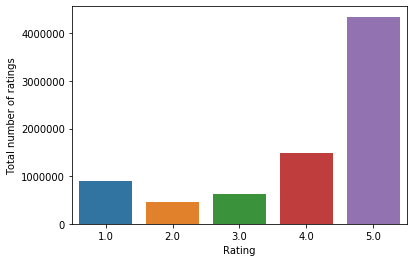

In [11]:
sns.countplot(x = 'Rating', data = df)
plt.ylabel('Total number of ratings');

## 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) -(5 Marks)

In [12]:
# Top 10 users based on number of ratings given (no. of products rated by user)
most_rated = df['userId'].value_counts()
#alternate approach
#most_rated = df.groupby('userId').size().sort_values(ascending=False)
most_rated.head(10)

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: userId, dtype: int64

In [13]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(most_rated >= 50)) )


 No of rated product more than 50 per user : 1540



In [14]:
df.shape

(7824482, 4)

In [15]:
#keep the users only who has given 50 or more number of ratings 
#counts = df['userId'].value_counts()
df1 = df[df['userId'].isin(most_rated[most_rated >= 50].index)]
df1.shape

(125871, 4)

In [16]:
#Dropping the Timestamp column
df1.drop(['timestamp'], axis=1,inplace=True)

In [17]:
df1.head()

,userId,productId,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [18]:
# Number of unique user id and product id in the data
print('Number of unique USERS in filtered data = ', df1['userId'].nunique())
print('Number of unique ITEMS in filtered data = ', df1['productId'].nunique())

Number of unique USERS in filtered data =  1540
Number of unique ITEMS in filtered data =  48190


After filtering the data for the users with min 50 ratings, the number of users came less than the number of products

## 3. Build Popularity Recommender model. ( 15 marks)

Popularity based (Non-personalised) recommendation system basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.


In [19]:
#Average rating of the product 
df1.groupby('productId')['Rating'].mean().head()

productId
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
Name: Rating, dtype: float64

In [20]:
#Average rating of the product sorted in Descending order
df1.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: Rating, dtype: float64

In [21]:
#Total no of rating for product
df1.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: Rating, dtype: int64

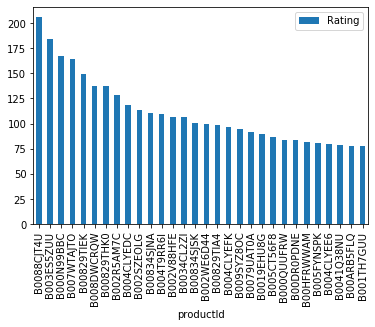

In [22]:
popular_products = pd.DataFrame(df1.groupby('productId')['Rating'].count())
popular_products.sort_values('Rating', ascending=False).head(30).plot(kind = "bar");

In [23]:
#Mean_ratings_count = pd.DataFrame(df1.groupby('productId')['Rating'].count())
popular_products["Mean_Ratings"] = pd.DataFrame(df1.groupby('productId')['Rating'].mean())
popular_products['Number_of_Ratings'] = pd.DataFrame(df1.groupby('productId')['Rating'].count())
popular_products.drop(['Rating'], axis=1,inplace=True)

In [24]:
popular_products.head()

,Mean_Ratings,Number_of_Ratings
productId,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


In [25]:
# Sort Products by top mean ratings
popular_products.sort_values(['Mean_Ratings', 'Number_of_Ratings'], ascending=[False, False])[:10]

,Mean_Ratings,Number_of_Ratings
productId,,
B000FQ2JLW,5.0,19
B00ISFNSBW,5.0,18
B000IJY8DS,5.0,17
B001TH7GUA,5.0,17
B00HZWJGS8,5.0,17
B005LDLP8W,5.0,16
B00HG1L334,5.0,16
B0012Y6HC8,5.0,15
B0033PRWSW,5.0,15


5 star rating products are rated by very few users. We may want to recommend most popular products to the new users though the rating may be smaller

In [26]:
popular_products['Number_of_Ratings'].min()

1

In [27]:
popular_products['Number_of_Ratings'].max()

206

In [28]:
Recommend = popular_products.sort_values(['Number_of_Ratings'], ascending= False)
Recommend.head(10)

,Mean_Ratings,Number_of_Ratings
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149
B008DWCRQW,4.094891,137
B00829THK0,4.416058,137
B002R5AM7C,4.125000,128
B004CLYEDC,4.669492,118


Most pupular products are having average rating less that 4.5 rating

In [29]:
#Recommending the top 10 products which are having higher then 4.5 rating and received more than 100 Ratings
Recommend[(Recommend[ "Mean_Ratings"] > 4.5) & (Recommend[ "Number_of_Ratings"] > 100)].head(10)

,Mean_Ratings,Number_of_Ratings
productId,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B004CLYEDC,4.669492,118
B002V88HFE,4.698113,106
B0034CL2ZI,4.632075,106
B00834SJSK,4.643564,101


### Most popular products are having lesser average rating but still higher than 4.5 rating can be recommended to a new user.

## 4. Split the data randomly into a train and test dataset. ( For example, split it in 70/30 ratio) ( 2 marks)

In [30]:
#Taking subset of the dataset to avoid memory issue for Collaborative Filtering model
df2=df1.iloc[:20000,0:]

In [31]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader # to define range of ratings
import os
from surprise.model_selection import train_test_split

In [32]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df2,reader)

In [33]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

## 5. Build Collaborative Filtering model. ( 20 marks)

Collaborative filtering (CF) Build Collaborative Filtering model (Personalised)is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item. Collaborative filtering has two sub-categories that are generally called memory based(User-User and Item-Item CF with similarity) and model-based(KNN, SVD).

### First, we are going to use User-User CF with KNN , User based CF is compact and will converge faster as the number of users came out lesser compared to number of products after filtering the data.

In [34]:
#Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options= {'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [35]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [36]:
#test_pred

## 6. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models. ( 5 marks)

In [37]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.1445


1.1445345006939274

### Second, we are going to use User-User CF with KNN , User based CF is compact and will converge faster as the number of users came out lesser compared to number of products after filtering the data.

In [38]:
#Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options= {'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [39]:
# run the trained model against the testset
test_pred1 = algo.test(testset)

In [40]:
#test_pred1

In [41]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred1, verbose=True)

Item-based Model : Test Set
RMSE: 1.2064


1.2063627808761437

User based collaborative filtering shows less RMSE value compared to the Item based collaoborative filtering.


### Third, we are going to use Model-based collaborative filtering system (Personalised) Singular Value Decomposition using TuncatedSVD


These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [42]:
df3=df1.iloc[:10000,0:]

In [43]:
df3.shape

(10000, 3)

In [44]:
ratings_matrix = df3.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B0002HTJ6M,B0002HTK7A,B0002HTK8Y,B0002HVIBG,B0002HVIC0,B0002I5RHG,B0002I5RI0,B0002I71LG,B0002I7288,B0002I8VVA
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A100WO06OQR8BQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A105TOJ6LTVMBG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10NMELR4KX0J6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10O7THJ2O20AG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.

In [45]:
ratings_matrix.shape

(1381, 5154)

Transposing the matrix

In [46]:
X = ratings_matrix.T
X.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105TOJ6LTVMBG,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,A10Y058K7B96C6,A10ZBR6O8S8OCY,A10ZFE6YE0UHW8,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0594481813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0970407998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0972683275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
X.shape

(5154, 1381)

Unique products in subset of data

In [48]:
X1 = X

In [49]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(5154, 10)

In [50]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(5154, 5154)

In [51]:
X.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105TOJ6LTVMBG,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,A10Y058K7B96C6,A10ZBR6O8S8OCY,A10ZFE6YE0UHW8,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0594481813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0970407998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0972683275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X.index[1000]

'B00005BKZZ'

Index # of product ID purchased by customer

In [53]:
i = "B00005BKZZ"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

1000

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [54]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(5154,)

In [55]:
correlation_product_ID[0:10]

array([ 0.9903971 , -0.27257852,  0.07401769, -0.52659357, -0.24136463,
       -0.24641388, -0.20779554, -0.23159417, -0.04146382, -0.24639935])

Recommending top 5 highly correlated products in sequence

In [56]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:5]

['0594451647', '8862935307', 'B00000J1P1', 'B00000J1US', 'B00000J570']

In [57]:
X.index[2000]

'B00006HQEI'

In [58]:
i = "B00006HQEI"
product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

2000

In [59]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(5154,)

In [60]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:5]

['9981734241', 'B000000O48', 'B00000J1E6', 'B00000J3NG', 'B00000J48J']

The Popularity-based recommender system is non-personalised and the recommendations are based on frequency counts, which may be not suitable to the user. The Popularity based model recommendeds the same set of 5 products to all.

Collaborative Filtering based model identifies the correlated products based on users ratings and suggest entire different list based on the user past purchase history. Model based collaborative filtering model (SVD method) identified the top 5 highly correlated products based on the user ratings. We can see the correlated products for product ids 1000 & 2000, the recoomendations are different.

## 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products. ( 10 marks)

In [61]:
def filterData(fileName):
    df=pd.read_csv(fileName,names=['userId', 'productId','Rating','timestamp'])
    most_rated = df['userId'].value_counts()
    return df[df['userId'].isin(most_rated[most_rated >= 50].index)]

In [62]:
global df_50
df_50 = filterData("ratings_Electronics.csv")
print(df_50.shape)
#df_50.head()

(125871, 4)


In [63]:
def extractPivot(df_x):
    global user_index
    # creating the pivit matrix of userId and productId
    pivot_df = df_x.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
    user_index =pivot_df.index.tolist()
    return pivot_df

In [64]:
print(extractPivot(df_50).shape)
#extractPivot(df_50).head()

(1540, 48190)


In [65]:
def replaceIndex(df_x):
    global def_index
    pivot_df = extractPivot(df_x)
    pivot_df['def_index'] = np.arange(0, pivot_df.shape[0],1) # adding index column to the matrix
    pivot_df1 = pivot_df.set_index(['def_index'])# after replacing first column with index column
    def_index = pivot_df1.index.tolist()
    return pivot_df1

In [66]:
print(replaceIndex(df_50).shape)
#replaceIndex(df_50).head()

(1540, 48190)


In [67]:
dict_ = {}
for i in def_index:
    dict_[i] = user_index[i]
#dict_

In [68]:
dict_[10]

'A10Y058K7B96C6'

In [69]:
from scipy.sparse.linalg import svds

In [70]:
def calculateSVD(df_x):
    pivot_df1 = replaceIndex(df_x)
    # Singular Value Decomposition to extract U, Sigma, Vt
    U, Sigma, Vt = svds(pivot_df1, k = 10) # k is the number of concepts
    # Construct diagonal array in SVD
    #print("Sigma Array:",Sigma)
    S = np.diag(Sigma) # convert python resultant sigma array to sigma diagonal matrix 
    #print("Sigma_Diag_Matrix:",S)
    return U, S, Vt

In [71]:
#calculateSVD(df_50)

In [72]:
def predictions(df_x):
    pivot_df1 = replaceIndex(df_x)
    U,S,Vt = calculateSVD(df_x)
    preds_df = pd.DataFrame(np.dot(np.dot(U,S),Vt), columns = pivot_df1.columns)
    mean_actual= pivot_df1.mean()
    mean_pred = preds_df.mean()
    rmse_df = pd.concat([pivot_df1.mean(), preds_df.mean()], axis=1)
    rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
    return pivot_df1, preds_df, rmse_df

In [73]:
pivot_df1, preds_df, rmse_df = predictions(df_50)

In [74]:
pivot_df1.mean().head()

productId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [75]:
preds_df.mean().head()

productId
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [76]:
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1) # you can remove it
print(rmse_df.shape)
rmse_df.head()

(48190, 3)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [77]:
from  sklearn.metrics import mean_squared_error

In [78]:
RMSE = (mean_squared_error(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings))**0.5
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.003298473944794172 



In [79]:
pivot_df1.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
def_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


From the comparison of above two tables, for all the sparse ratings in the original matrix, algoritm has predicted the ratings based on the available user ratings.

In [81]:
#predictions(df_50)

In [82]:
def recommend_items(userID, num_recommendations, fileName):
    
    df_50 = filterData(fileName)
    pivot_df1, preds_df, rmse_df = predictions(df_50)
            
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df1.iloc[user_idx].sort_values(ascending=False) #user_idx is the row number
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   # why 0? because these are the products the user has not rated, so we 
    # have to recommend from these to him
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))


In [83]:
userID = 10
print("User_Name:", dict_[userID-1])
n = 5
fileName="ratings_Electronics.csv"
df_recom = recommend_items(userID, n, fileName)

User_Name: A10X9ME6R66JDX

Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          1.594319
B003ES5ZUU                  0.0          1.333773
B001TH7GUU                  0.0          0.878497
B000QUUFRW                  0.0          0.722314
B002WE6D44                  0.0          0.718801


In [84]:
userID = 1000
print("User_Name:", dict_[userID-1])
n = 5
fileName="ratings_Electronics.csv"
df_recom = recommend_items(userID, n, fileName)

User_Name: A3G007LQX6KGOD

Below are the recommended items for user(user_id = 1000):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.425913
B00829TIEK                  0.0          1.223854
B002R5AM7C                  0.0          1.052991
B004CLYEDC                  0.0          0.945831
B00HFRWWAM                  0.0          0.677177


## 8. Summarise your insights. ( 10 marks)

The Popularity-based recommender system is non-personalised and the recommendations are based on frequency counts, which may be not suitable to the user. The Popularity based model recommendeds the same set of 5 products to all.

Collaborative Filtering is a personalised recommender system and it identifies the correlated products based on users ratings/past behavior of the user and suggests entire different list based on the user past purchase history. Model based collaborative filtering model (SVD method) identified the top 5 highly correlated products based on the user ratings.

In the above exercize, model has predicted the ratings for all the products with no ratings and recommneded 5 completely different products for the User IDs 10 and 1000 based on other user-item ratings.